# Kaggle - Allstate Claim Severity - [LINK](https://www.kaggle.com/competitions/allstate-claims-severity/data) 

## EDA v2

In [287]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import statsmodels as sm
import xgboost as xgb


import plotly.figure_factory as ff
import plotly.express as px
import sklearn.preprocessing as sklpp
from sklearn.decomposition import PCA
from sklearn.preprocessing import OrdinalEncoder

from prettytable import PrettyTable

In [288]:
import os
import gc
import warnings

### Goals 
- **Import & basic preparation**

- **Data cleaning**
    - Outliers
    - Missing values
    - Duplicate data
    - Data Quality Measures
        - Accuracy
        - Completeness
        - Timeliness
        - Believability
        - Interoperability

- **Graphs** *(mean, median, mode, ...)*
    - Correlation Map
    - Boxplot
    - Histogram
    - Quantile Plot
    - Scatter Plot (correlation)

### Matt Objective Updates

1. Identify
    - *Target*
    - *Predictors* & their *Exposure*

2. Visuals of *Predictors* & *Target*

3. Frequency tables for *Categorical/Nominal* *Predictors*

4. Start creating different models (in different notebooks)

## (1) Import & Basic Preparation

In [289]:
PATH = os.getcwd()
print(PATH)
PATH = PATH.split('/')[:-1]
PATH = ''.join([str(folder + '/') for folder in PATH])
print(PATH)

/Users/education/Documents/Github Repos/Personal/Datasets_EDA/src/Allstate Claims Severity/code
/Users/education/Documents/Github Repos/Personal/Datasets_EDA/src/Allstate Claims Severity/


#### (1.i)
*'train.csv'* file does go on longer then line 188,320. But there appears to be some formatting issue after that line. I tried to write a separate python file that can add line by line of *'train.csv'* into a Panda's Dataframe but that seem to take to long. So I'll use up to 188,320 for now.

In [290]:
train_df = pd.read_csv(
    filepath_or_buffer= os.path.join(PATH, 'train.csv'),
    on_bad_lines= 'skip' # issue on line 188320
)

Removing the last line in the dataframe that is part of the issue I mentioned above ^. 

In [291]:
print(train_df.iloc[188317:188319]) # need to drop 188318 as it doesn't fit with data 

                   id      cat1      cat2      cat3      cat4      cat5  \
188317  587633.000000         B         A         A         B         A   
188318       0.348388   .672862   .551054   .344450   .447670   .538810   

            cat6      cat7      cat8      cat9  ...     cont6     cont7  \
188317         A         A         A         A  ...  0.844563  0.533048   
188318   .492200   .481306   .654753   .406237  ...       NaN       NaN   

          cont8    cont9   cont10    cont11    cont12    cont13   cont14  \
188317  0.97123  0.93383  0.83814  0.932195  0.946432  0.810511  0.72146   
188318      NaN      NaN      NaN       NaN       NaN       NaN      NaN   

           loss  
188317  4751.72  
188318      NaN  

[2 rows x 132 columns]


In [292]:
train_df.drop(
    inplace= True,
    index= 188318,
    axis= 'index'
)
print(train_df.iloc[188317:188319]) # need to drop 188318 as it doesn't fit with data

              id cat1 cat2 cat3 cat4 cat5 cat6 cat7 cat8 cat9  ...     cont6  \
188317  587633.0    B    A    A    B    A    A    A    A    A  ...  0.844563   

           cont7    cont8    cont9   cont10    cont11    cont12    cont13  \
188317  0.533048  0.97123  0.93383  0.83814  0.932195  0.946432  0.810511   

         cont14     loss  
188317  0.72146  4751.72  

[1 rows x 132 columns]


In [293]:
print(train_df.head(5))

     id cat1 cat2 cat3 cat4 cat5 cat6 cat7 cat8 cat9  ...     cont6     cont7  \
0   1.0    A    B    A    B    A    A    A    A    B  ...  0.718367  0.335060   
1   2.0    A    B    A    A    A    A    A    A    B  ...  0.438917  0.436585   
2   5.0    A    B    A    A    B    A    A    A    B  ...  0.289648  0.315545   
3  10.0    B    B    A    B    A    A    A    A    B  ...  0.440945  0.391128   
4  11.0    A    B    A    B    A    A    A    A    B  ...  0.178193  0.247408   

     cont8    cont9   cont10    cont11    cont12    cont13    cont14     loss  
0  0.30260  0.67135  0.83510  0.569745  0.594646  0.822493  0.714843  2213.18  
1  0.60087  0.35127  0.43919  0.338312  0.366307  0.611431  0.304496  1283.60  
2  0.27320  0.26076  0.32446  0.381398  0.373424  0.195709  0.774425  3005.09  
3  0.31796  0.32128  0.44467  0.327915  0.321570  0.605077  0.602642   939.85  
4  0.24564  0.22089  0.21230  0.204687  0.202213  0.246011  0.432606  2763.85  

[5 rows x 132 columns]


In [294]:
print(train_df.shape)

(188318, 132)


#### (1.ii)
Defining constants for later use.

In [295]:
X_CAT = [str('cat' + str(i)) for i in range(1, 117, 1)]
X_CONT = [str('cont' + str(i)) for i in range(1, 15, 1)]
Y = 'loss'

CAT_X_Y, CONT_X_Y = X_CAT.copy(), X_CONT.copy()
CAT_X_Y.append(Y)
CONT_X_Y.append(Y)

#### (1.iii)
Setting datatype's of attributes/features/columns.

In [296]:
print(train_df.dtypes)

id        float64
cat1       object
cat2       object
cat3       object
cat4       object
           ...   
cont11    float64
cont12    float64
cont13    float64
cont14    float64
loss      float64
Length: 132, dtype: object


In [297]:
# https://pandas.pydata.org/pandas-docs/stable/user_guide/basics.html#basics-dtypes

train_df['id'].astype('int32')
train_df['loss'].astype('float32')
# train_df[X_CAT].astype('string')
train_df[X_CONT].astype('float32')
print(train_df.dtypes)

id        float64
cat1       object
cat2       object
cat3       object
cat4       object
           ...   
cont11    float64
cont12    float64
cont13    float64
cont14    float64
loss      float64
Length: 132, dtype: object


(1.iv)
Mapping for categorical

In [298]:
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html

le = OrdinalEncoder(
    categories= "auto",
    dtype= np.int32
    # handle_unknown= "error",
    #unknown_value: float | int | None = None,
    #encoded_missing_value: float | int = ...
)

train_df[X_CAT] = le.fit_transform(
    X= train_df[X_CAT]
)
print(train_df[X_CAT].head(5))
print(le.categories_)

   cat1  cat2  cat3  cat4  cat5  cat6  cat7  cat8  cat9  cat10  ...  cat107  \
0     0     1     0     1     0     0     0     0     1      0  ...       9   
1     0     1     0     0     0     0     0     0     1      1  ...      10   
2     0     1     0     0     1     0     0     0     1      1  ...       5   
3     1     1     0     1     0     0     0     0     1      0  ...      10   
4     0     1     0     1     0     0     0     0     1      1  ...       6   

   cat108  cat109  cat110  cat111  cat112  cat113  cat114  cat115  cat116  
0       6      45      28       2      19      55       0      14     269  
1      10      33      65       0      22      38       0      14      85  
2       0       2      85       0      28       5       0       8     153  
3      10      33      67       2      39       4       0      14      79  
4       1      66      50       2      50      38       0      10      55  

[5 rows x 116 columns]
[array(['A', 'B'], dtype=object), array(['A',

In [299]:
gc.collect()

49323

## (2) Data Cleaning

- Missing values
- Duplicate data
- Outliers
- Data Quality Measures
    - Accuracy
    - Completeness
    - Timeliness
    - Believability
    - Interoperability

#### (2.a) Missing Data

In [300]:
null_rows = train_df.isnull().any(axis=1)
print(null_rows.describe()) # seems to be no missing data

count     188318
unique         1
top        False
freq      188318
dtype: object


#### (2.b) Duplicate Rows

In [301]:
dup_rows = train_df.duplicated()
print(dup_rows.describe()) # no duplicates

count     188318
unique         1
top        False
freq      188318
dtype: object


#### (2.c) Remove Outliers

(2.c.i) Categorical Outliers

In [302]:
# !!! Have yet to remove any categorical outliers !!!

In [303]:
table = PrettyTable()
table.field_names = ['Column_Type', 'count', 'mean', 'median', 'mode', 'std', 'min', 'max']

for col_name in train_df[X_CAT].columns:
    col = train_df[[col_name, 'loss']]
    
    for i, other in enumerate(col.groupby(col_name)):
        cat_type, col_cat_df = other
        r_type = f"{col_name}.{cat_type}"
        num_amount = col_cat_df.shape[0]
        percentage = f"{(100 * col_cat_df.shape[0] / col.shape[0]):2.2f}"
        
        stats = col_cat_df['loss'].describe()
        count = f"{(stats['count']):2.2f} | {percentage}%"
        mean = f"{(stats['mean']):2.2f}"
        min = f"{(stats['min']):2.2f}"
        max = f"{(stats['max']):2.2f}"
        std = f"{(stats['std']):2.2f}"
        
        median = f"{(col_cat_df['loss'].median()):2.2f}"
        mode = f"{(col_cat_df['loss'].mode()[0]):2.2f}"
        
        
        new_row = [r_type, count, mean, median, mode, std, min, max]
        if i == len(col[col_name].unique()) - 1:
            table.add_row(new_row, divider=True)
            continue
        table.add_row(new_row)

print(table)

+-------------+--------------------+----------+----------+----------+----------+----------+-----------+
| Column_Type |       count        |   mean   |  median  |   mode   |   std    |   min    |    max    |
+-------------+--------------------+----------+----------+----------+----------+----------+-----------+
|    cat1.0   | 141550.00 | 75.17% | 3408.09  | 2458.69  |  580.00  | 3122.44  |   0.67   | 121012.25 |
|    cat1.1   | 46768.00 | 24.83%  | 1915.20  | 1444.86  |  580.00  | 1666.08  |   5.25   |  79623.52 |
+-------------+--------------------+----------+----------+----------+----------+----------+-----------+
|    cat2.0   | 106721.00 | 56.67% | 2454.14  | 1739.25  |  580.00  | 2361.31  |   0.67   | 121012.25 |
|    cat2.1   | 81597.00 | 43.33%  | 3800.10  | 2833.99  |  580.00  | 3338.42  |   5.25   | 106863.00 |
+-------------+--------------------+----------+----------+----------+----------+----------+-----------+
|    cat3.0   | 177993.00 | 94.52% | 2902.22  | 2033.38  |  580.

(2.c.ii) Continuous Outliers

In [304]:
std_max = 3
show_image = True

'loss' removing 3524 thats 3x away from mean. 0.02%


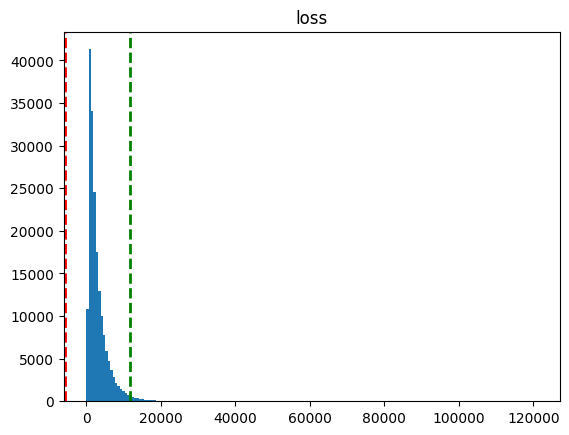

In [305]:
# https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/

for col_name, col in train_df[CONT_X_Y].items():
    initial_rows = col.shape[0]
    
    col_mean, col_std = col.mean(), col.std()    
    lower_b, upper_b = col_mean - (col_std * std_max), col_mean + (col_std * std_max)

    col_tf = (col < lower_b) | (col > upper_b)
    num_rows_remove = col_tf[col_tf == True].count()
    
    if num_rows_remove > 0:
        print(f"\'{col_name}\' removing {num_rows_remove} thats {std_max}x away from mean. {(num_rows_remove/initial_rows):2.2f}%")
        
        train_df.drop(
            index= train_df[col_tf].index,
            axis= 0,
            inplace= True
        )
        
        if show_image == True:
            fig = plt.hist(
                x= col,
                bins= int(len(col) / 1000)
            )
            plt.axvline(
                x= lower_b,
                color= 'r',
                linestyle= '--',
                linewidth= 2
            )
            plt.axvline(
                x= upper_b,
                color= 'g',
                linestyle= '--',
                linewidth= 2
            )
            plt.title(label= col_name)
            plt.show()

#### (2.d) Data Quality Measures
- Accuracy
- Completeness
- Timeliness
- Believability
- Interoperability

Not knowing what the columns are makes it hard to preform this assessment.

In [306]:
gc.collect()

301

## (3) Graphs
- Correlation Map
- Boxplot
- Histogram
- Quantile Plot
- Scatter Plot (correlation)
- Mean, Median, Mode, etc...

*Continuous_X* v.s. Y: **Correlation**

In [307]:
train_df[CONT_X_Y].corr(method='pearson')

,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
cont1,1.000000,-0.086084,-0.445739,0.367092,-0.026904,0.758448,0.372800,0.360784,0.929662,0.808882,0.600279,0.618301,0.533174,0.056446,-0.022555
cont2,-0.086084,1.000000,0.455022,0.040079,0.193995,0.013180,0.042289,0.136785,-0.034071,0.062029,0.112586,0.101999,0.023603,-0.046239,0.107156
cont3,-0.445739,0.455022,1.000000,-0.341046,0.093218,-0.353002,0.088480,-0.186067,-0.418210,-0.327669,0.018320,-0.000701,-0.416981,-0.040542,0.081097
cont4,0.367092,0.040079,-0.341046,1.000000,0.162806,0.221918,-0.110908,0.528736,0.328723,0.283136,0.123252,0.132614,0.177661,0.017719,-0.029570
cont5,-0.026904,0.193995,0.093218,0.162806,1.000000,-0.150689,-0.248216,0.008442,-0.089954,-0.066179,-0.150728,-0.147246,-0.086051,-0.021885,-0.001851
cont6,0.758448,0.013180,-0.353002,0.221918,-0.150689,1.000000,0.662385,0.438284,0.797736,0.883356,0.776231,0.787610,0.816465,0.042130,0.007888
cont7,0.372800,0.042289,0.088480,-0.110908,-0.248216,0.662385,1.000000,0.144777,0.388290,0.496550,0.746581,0.742365,0.296531,0.021866,0.054381
cont8,0.360784,0.136785,-0.186067,0.528736,0.008442,0.438284,0.144777,1.000000,0.452759,0.336292,0.304546,0.317945,0.477875,0.043995,0.020427
cont9,0.929662,-0.034071,-0.418210,0.328723,-0.089954,0.797736,0.388290,0.452759,1.000000,0.785928,0.611497,0.630063,0.642154,0.073942,-0.000910
cont10,0.808882,0.062029,-0.327669,0.283136,-0.066179,0.883356,0.496550,0.336292,0.785928,1.000000,0.705597,0.716464,0.707548,0.041601,-0.006588


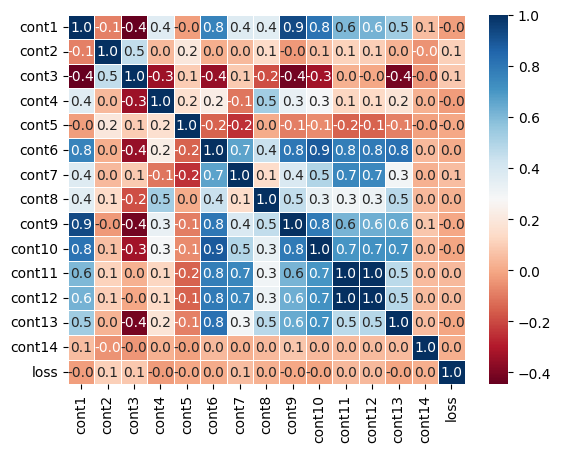

In [308]:
# https://seaborn.pydata.org/generated/seaborn.heatmap.html#seaborn.heatmap
sns.heatmap(
    data= train_df[CONT_X_Y].corr(method='pearson'),
    annot= True,
    cmap= 'RdBu', # https://matplotlib.org/stable/users/explain/colors/colormaps.html
    fmt= '.1f',
    linewidth= .5,
    # vmin= -1,
    # vmax= 1
)
plt.show()

**Explanation**
1. Most of the Continuous_X has very little correlation with Y

2. Some of the Continuous_X attributes do show positive/negative correlation with one another.
- Difficulty in interpreting, as it makes it harder to pin-point which *X* is driving a change in *Y*: *[Detecting and Remedying Multicollinearity](https://hex.tech/blog/detecting-and-remedying-multicollinearity/)*
- Multi-collinearity increase variance in the model, and can lead to overfitting: *[Detecting and Remedying Multicollinearity](https://hex.tech/blog/detecting-and-remedying-multicollinearity/)*

3. Solutions
- PCA. Helps by combining 2 or more *X* variables into 1 *principle component* which can reduce/eliminate collinearity: *[Detecting and Remedying Multicollinearity](https://hex.tech/blog/detecting-and-remedying-multicollinearity/)*

In [309]:
# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
pca = PCA(
    n_components= 'mle',
    copy= True,
    # whiten= False,
    svd_solver = "full", # ['auto', 'full', 'arpack', 'randomized']
    # tol = 0.0,
    # iterated_power= "auto",
    # n_oversamples=  10,
    # power_iteration_normalizer= "auto", # ['auto', 'QR', 'LU', 'none']
    random_state= 4095
)

pca_df = pca.fit_transform(train_df[X_CONT])
pca_df = pd.DataFrame(
    data= pca_df,
    columns= [f'PCA_{i}' for i in range(pca_df.shape[1])]
)
print(pca_df.head(5))

      PCA_0     PCA_1     PCA_2     PCA_3     PCA_4     PCA_5     PCA_6  \
0  0.550599 -0.411950 -0.307843  0.134964 -0.082166 -0.013284  0.218446   
1 -0.207707 -0.082505  0.487656 -0.142627 -0.098900 -0.154674 -0.175909   
2 -0.571126  0.076657 -0.298883  0.272579 -0.032031  0.044988  0.004019   
3 -0.298094  0.016513 -0.093690  0.094091  0.005818 -0.255664  0.018059   
4 -0.797735 -0.218435 -0.117087 -0.054104 -0.196163  0.175076 -0.148819   

      PCA_7     PCA_8     PCA_9    PCA_10    PCA_11    PCA_12  
0  0.206414 -0.284912 -0.047432 -0.009540 -0.000909  0.000617  
1  0.104562  0.026866 -0.072275  0.025790  0.008123 -0.025638  
2  0.026799 -0.008022  0.135244 -0.098849  0.010904  0.077359  
3  0.133726 -0.072741 -0.054699  0.010912 -0.018762 -0.002832  
4  0.029760 -0.105488 -0.027269  0.030110 -0.015573  0.008082  


In [310]:
pca_df['loss'] = train_df['loss']
print(pca_df.corr(method='pearson'))

               PCA_0         PCA_1         PCA_2         PCA_3         PCA_4  \
PCA_0   1.000000e+00  3.858591e-16  1.714484e-16  1.703488e-17  2.148310e-16   
PCA_1   3.858591e-16  1.000000e+00  1.667758e-16 -4.368495e-17 -1.525347e-16   
PCA_2   1.714484e-16  1.667758e-16  1.000000e+00  2.205548e-16  9.223642e-16   
PCA_3   1.703488e-17 -4.368495e-17  2.205548e-16  1.000000e+00 -2.116714e-16   
PCA_4   2.148310e-16 -1.525347e-16  9.223642e-16 -2.116714e-16  1.000000e+00   
PCA_5  -1.933130e-16 -1.771701e-16 -3.299114e-16 -1.762523e-16 -1.497820e-16   
PCA_6  -4.429181e-16  1.195637e-16  3.532905e-16 -1.183626e-16 -9.618049e-16   
PCA_7  -6.648794e-17 -1.636955e-16 -2.910593e-16 -4.197421e-17  2.057379e-16   
PCA_8  -9.217145e-18 -2.055391e-17  1.510306e-17 -1.278590e-16  2.049446e-16   
PCA_9  -5.739244e-17 -1.580294e-16  1.106259e-16  9.935529e-17 -1.127826e-16   
PCA_10 -2.920249e-17  2.702787e-17  1.342089e-17 -8.566643e-18  2.248585e-16   
PCA_11  4.921152e-17 -6.630623e-18  1.57

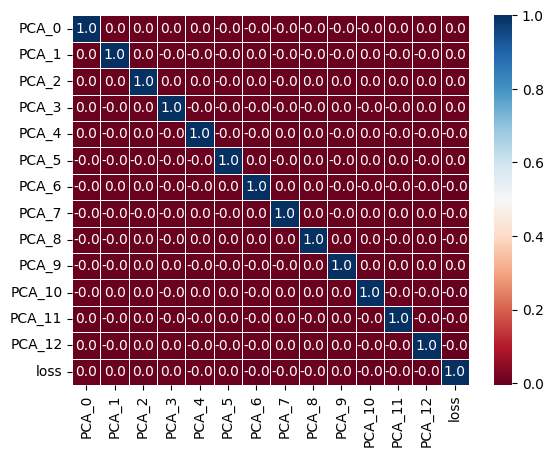

In [311]:
sns.heatmap(
    data= pca_df.corr(method='pearson'),
    annot= True,
    cmap= 'RdBu', # https://matplotlib.org/stable/users/explain/colors/colormaps.html
    fmt= '.1f',
    linewidth= .5,
    # vmin= -1,
    # vmax= 1
)
plt.show()

*Categorical_X* v.s. Y: **Correlation**

In [312]:
# idk how

Continuous Columns Correlation Box Plot

In [313]:
num_samples = int(train_df.shape[0] / 500)
train_sample_df = train_df.sample(
    n = num_samples,
    axis= 0
)

In [314]:
# https://plotly.com/python/box-plots/

import plotly.graph_objects as go

fig = go.Figure()
for lab, col in train_sample_df[X_CONT].items():
    fig.add_trace(go.Box(
        y=col,
        name= lab,
        visible= 'legendonly'
        )
    )
fig.show()

Scatter Plot

In [315]:
fig = go.Figure()
fig = px.scatter(
    data_frame= train_sample_df[CONT_X_Y],
    x= X_CONT,
    y= 'loss',
    render_mode= 'webgl'
)
fig.show()

Histogram

In [316]:
fig = go.Figure()
for lab, col in train_sample_df[X_CONT].items():
    fig.add_trace(go.Histogram(
        x=col,
        name= lab,
        visible= 'legendonly',
        )
    )
fig.show()

### Save final dataframe

In [317]:
train_df.to_csv(
    path_or_buf= os.path.join(PATH, 'code', 'train_v2.csv'),
    index= False
)


## Matt Objective Updates

1. Identify
    - *Target*
    - *Predictors* & their *Exposure*

2. Visuals of *Predictors* & *Target*

3. Frequency tables for *Categorical/Nominal* *Predictors*

4. Start creating different models (in different notebooks)